In [2]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

import copy

import sklearn.metrics as skm

C:\Users\DOANTR~1\AppData\Local\Temp/ipykernel_8668/4004001396.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create the DL model

In [3]:
class the_net(nn.Module):
    def __init__(self):
        super().__init__()

        # Input layer
        self.input = nn.Linear(100, 100)

        # Hidden layer
        self.fc1 = nn.Linear(100, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
    
        # Output layer
        self.output = nn.Linear(100, 2)
    
    # Forward pass
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return self.output(x)

# Explore the initialized weights

In [4]:
# Create an instance of the model
net = the_net()
print(net)

the_net(
  (input): Linear(in_features=100, out_features=100, bias=True)
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=2, bias=True)
)


There are 402   bias parameters.
There are 40200 weight parameters.


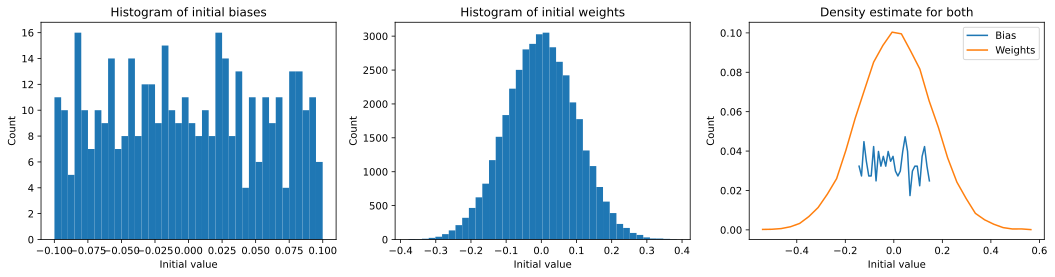

In [14]:
# Collect all weights and biases
all_weight = np.array([])
all_biases = np.array([])

for p in net.named_parameters():
    if ('bias'     in p[0]):
        all_biases = np.concatenate((all_biases, p[1].data.numpy().flatten()), axis=0)
    elif ('weight' in p[0]):
        all_weight = np.concatenate((all_weight, p[1].data.numpy().flatten()), axis=0)
    
# How many?
print('There are {:<5} bias parameters.'.format(len(all_biases)))
print('There are {:<5} weight parameters.'.format(len(all_weight)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[0].hist(all_biases, 40)
ax[0].set_title('Histogram of initial biases')

ax[1].hist(all_weight, 40)
ax[1].set_title('Histogram of initial weights')

# Collect histogram data to show as line plots
y_B, x_B = np.histogram(all_biases, bins=30)
y_W, x_W = np.histogram(all_weight, bins=30)

ax[2].plot(x_B[1:] + x_B[:-1] / 2, y_B / np.sum(y_B), label='Bias')
ax[2].plot(x_W[1:] + x_W[:-1] / 2, y_W / np.sum(y_W), label='Weights')
ax[2].set_title('Density estimate for both')
ax[2].legend()
ax[2].set_ylabel('Probability')

# Plot adjustments common to all subplots
for i in range(3):
    ax[i].set_xlabel('Initial value')
    ax[i].set_ylabel('Count')

plt.show()

# Layer-specific distributions

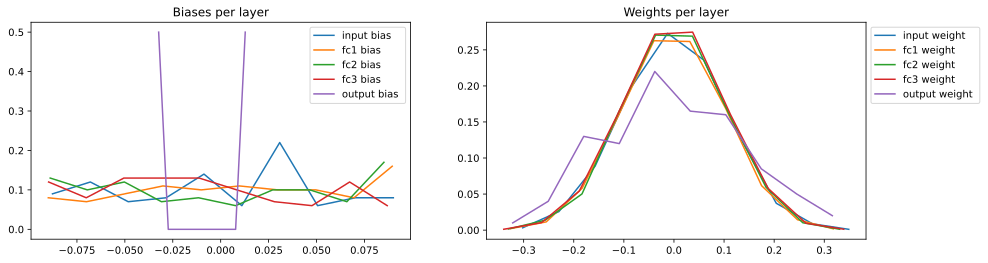

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

for p in net.named_parameters():

    # Get the data and compute their histogram
    params_data = p[1].data.numpy().flatten()
    y, x = np.histogram(params_data, 10)

    # For the bias
    if ('bias' in p[0]):
        ax[0].plot((x[1:] + x[:-1]) / 2, y / np.sum(y), label=f'{p[0][:-5]} bias ')
    
    # For the weight
    elif ('weight' in p[0]):
        ax[1].plot((x[1:] + x[:-1]) / 2, y / np.sum(y), label=f'{p[0][:-7]} weight ')
    
ax[0].set_title('Biases per layer')
ax[0].legend()
ax[1].set_title('Weights per layer')
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.show()

In [10]:
# What's up with the weird output bias distribution??
print( net.output.bias.data )

tensor([0.0567, 0.0154])


In [ ]:
# Check out the docstring for linear layers
nn.Linear?

In [11]:
# Let's test whether the numbers match our prediction from the formula
# Empirical bias range
bias_range = [torch.min(net.fc1.bias.data).item(), torch.max(net.fc1.bias.data).item()]
bias_count = len(net.fc1.bias.data)

# Theoretical expected value
sigma = np.sqrt(1 / bias_count)

# Drum rolllllll.....
print(f'Theoretical sigma = {sigma}')
print(f'Empirical range   = {bias_range}')

Theoretical sigma = 0.1
Empirical range   = [-0.09620773047208786, 0.09776251763105392]


# Now to initialize the weights using the Xavier method

In [12]:
# Create a new instance of the model
net = the_net()

# Change the weights (leave biases as Kaiming (default))
for p in net.named_parameters():
    if ('weight' in p[0]):
        nn.init.xavier_normal_(tensor=p[1].data)

In [ ]:
# Note: it is unconventional to have Kaiming biases and Xavier weights.
# Scroll up and re-run the previous weights visualization cells with the new network.
# Then continue below.

In [13]:
# Test whether the numbers match our predictions from the formula
# Empirical weight standard deviation
weight_var   = torch.var(net.fc1.weight.data.flatten()).item()
weight_count = len(net.fc1.weight.data)

# Theoretical expected value
sigma_2 = 2 / (weight_count + weight_count)

print(f'Theoretical sigma = {sigma_2}')
print(f'Empirical range   = {weight_var}')

Theoretical sigma = 0.01
Empirical range   = 0.009857188910245895


In [ ]:
# Note: There are several other weights initialization methods availabe in PyTorch.
#       See https://pytorch.org/docs/stable/nn.init.html

# Additional explorations

In [ ]:
# 1) Explore the weight initialization options using PyTorch's functions (nn.init.<method>). 
#    For example: apply Xavier-uniform, Kaiming, constant (this is what we did in the first video of this section).
# 